In [1]:
%load_ext autoreload
%autoreload 2

from multicamera_acquisition.acquisition import refactor_acquire_video, AcquisitionLoop, reset_loggers
from multicamera_acquisition.writer import NVC_Writer, FFMPEG_Writer
from multicamera_acquisition.interfaces.microcontroller import Microcontroller 
from multicamera_acquisition.config import (
    load_config,
)

import datetime


In [11]:
# Recording params
fps = 120
rec_time_s = 60
base_path = R'D:\Jonah\2023_12_26_6cam_testing\tmp'
mouse = "J01701"
logging_level = "INFO"
config_filepath = R'D:/Jonah/2023_12_26_6cam_testing/JP219_6+2_120hz.yaml'

In [12]:
config = load_config(config_filepath)

In [13]:
config

{'acq_loop': {'display_every_n': 1,
  'dropped_frame_warnings': False,
  'max_frames_to_acqure': None},
 'cameras': {'azure_bottom': {'brand': 'azure',
   'depth_mode': 'NFOV_UNBINNED',
   'display': {'display_frames': False, 'display_range': (0, 255)},
   'fps': 30,
   'id': '000693321712',
   'name': 'azure_bottom',
   'subordinate_delay_off_master_usec': 0,
   'sync_mode': 'subordinate',
   'synchronized_images_only': False,
   'trigger': {},
   'writer': {'camera_name': 'azure_bottom',
    'depth': False,
    'fps': 30,
    'gpu': None,
    'loglevel': 'error',
    'max_video_frames': 2592000,
    'output_px_format': 'yuv420p',
    'pixel_format': 'gray8',
    'preset': 'ultrafast',
    'quality': 15,
    'type': 'ffmpeg',
    'video_codec': 'libx264'},
   'writer_depth': {'camera_name': 'azure_bottom',
    'depth': True,
    'fps': 30,
    'gpu': None,
    'loglevel': 'error',
    'max_video_frames': 2592000,
    'pixel_format': 'gray16',
    'quality': 15,
    'type': 'ffmpeg',
 

In [14]:
datestr = datetime.datetime.now().strftime("%Y%m%d")
recording_name = f"{datestr}_{mouse}"
recording_name

'20240123_J01701'

In [ ]:
reset_loggers()

save_loc, first_video_file_name, full_config = refactor_acquire_video(
    base_path,
    config,
    recording_duration_s=rec_time_s,
    recording_name=recording_name,
    append_datetime=False,
    overwrite=False,
    logging_level=logging_level
)

2024-01-23 22:36:40,114 - main_acq_logger - INFO - Finding microcontroller...
2024-01-23 22:36:40,437 - main_acq_logger - INFO - Found ready microcontroller on port: COM3
2024-01-23 22:36:40,437 - main_acq_logger - INFO - Opening subprocesses and cameras, this may take a moment...
2024-01-23 22:36:50,762 - main_acq_logger - INFO - Starting cameras...
2024-01-23 22:36:51,636 - main_acq_logger - INFO - Starting microcontroller...


Recording Progress: 3.33%

## Plot data

In [7]:
from pathlib2 import Path
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.set_loglevel (level = 'warning')

azure_bottom


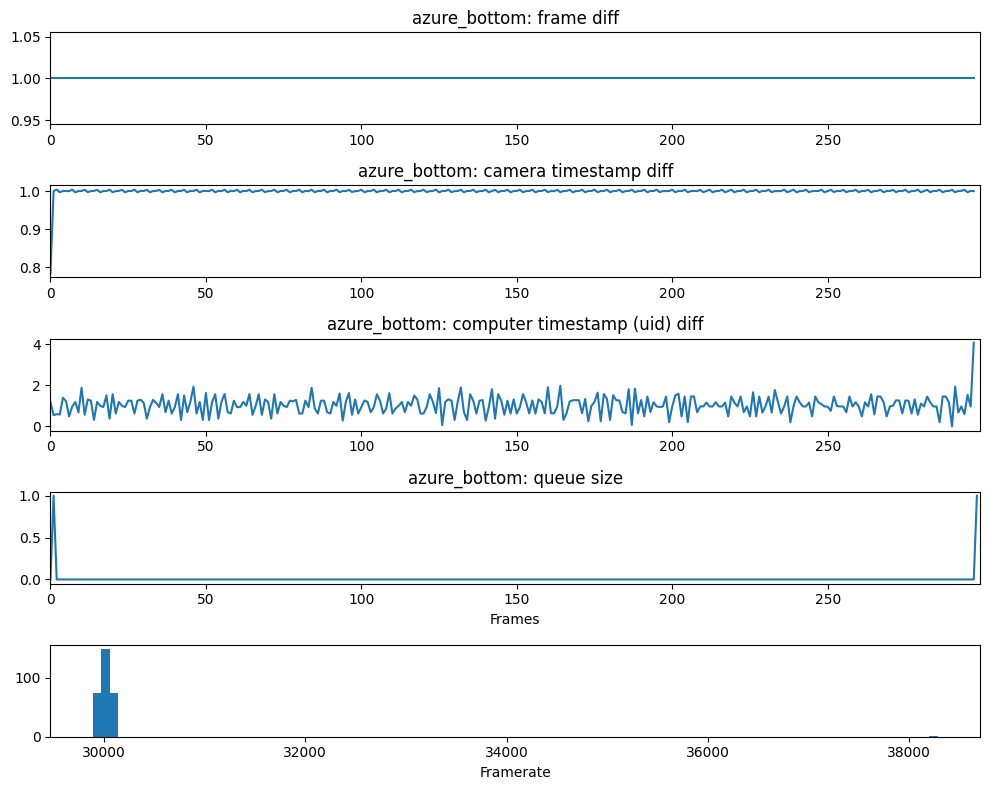

0.009926122
30021.79501722828
azure_top


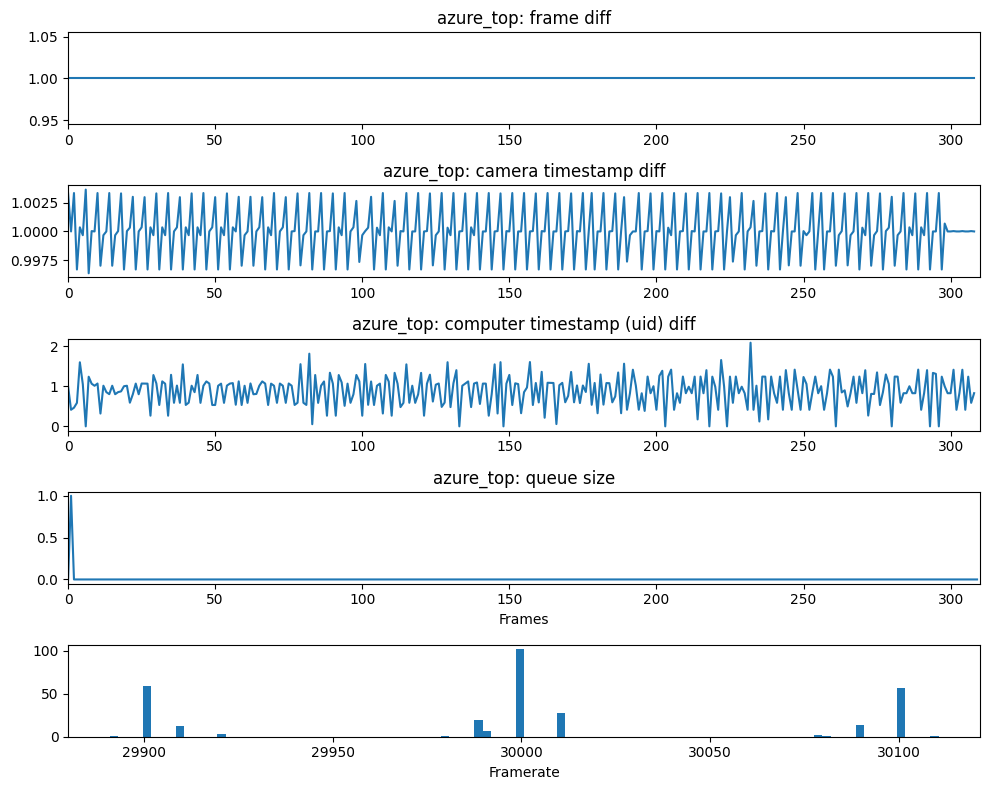

0.010300133000000001
29999.612626361235
bottom


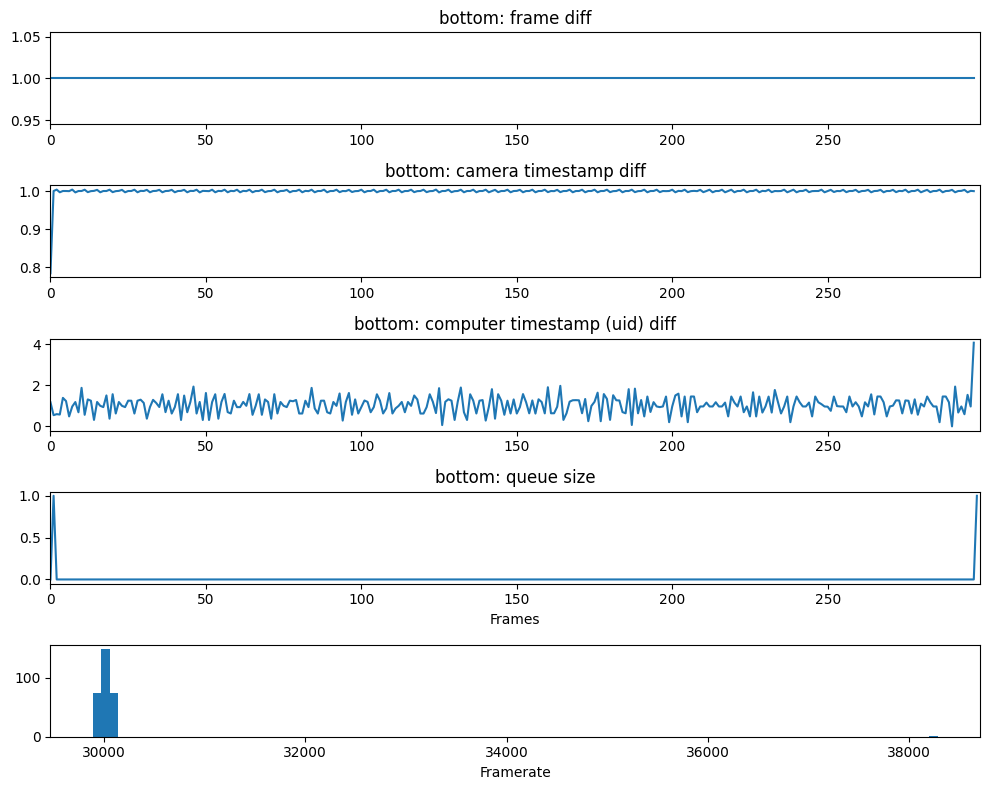

0.009926122
30021.79501722828
side1


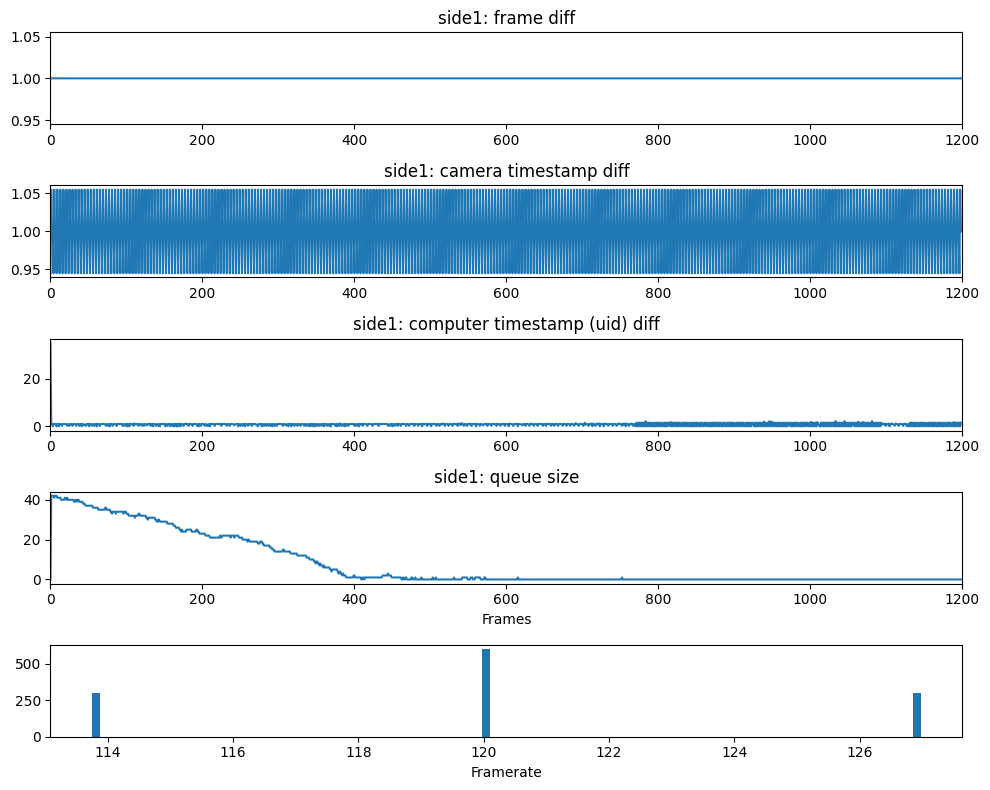

9.99178882
119.99853295538324
side2


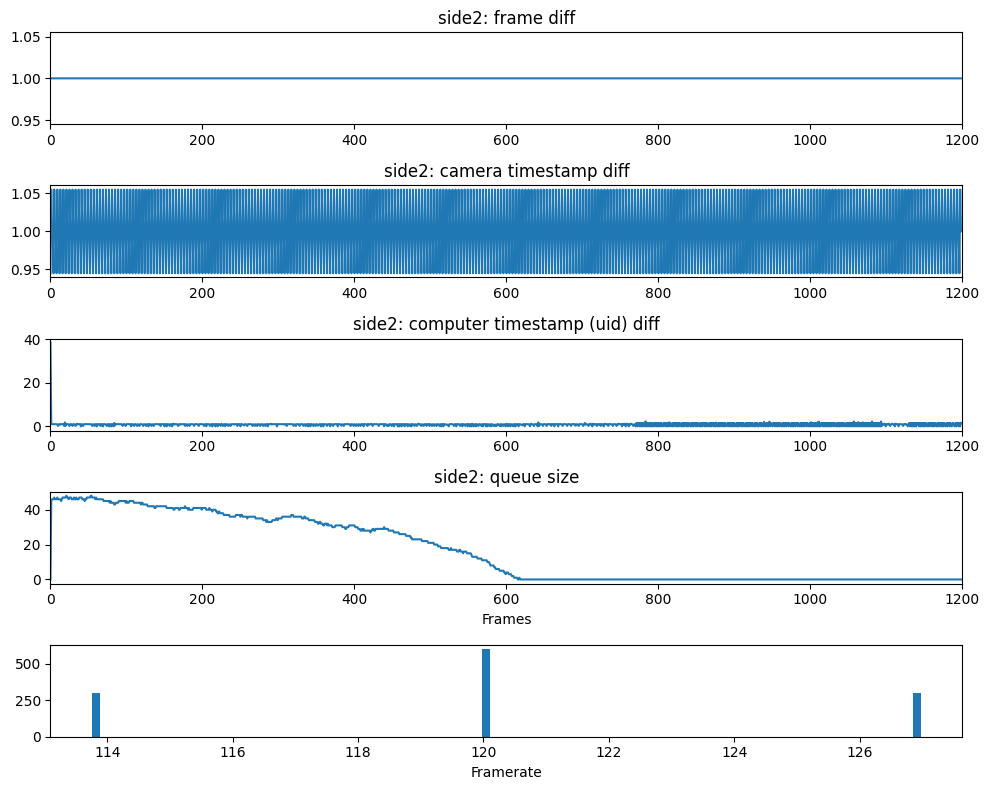

9.99180651
119.99832050390656
side3


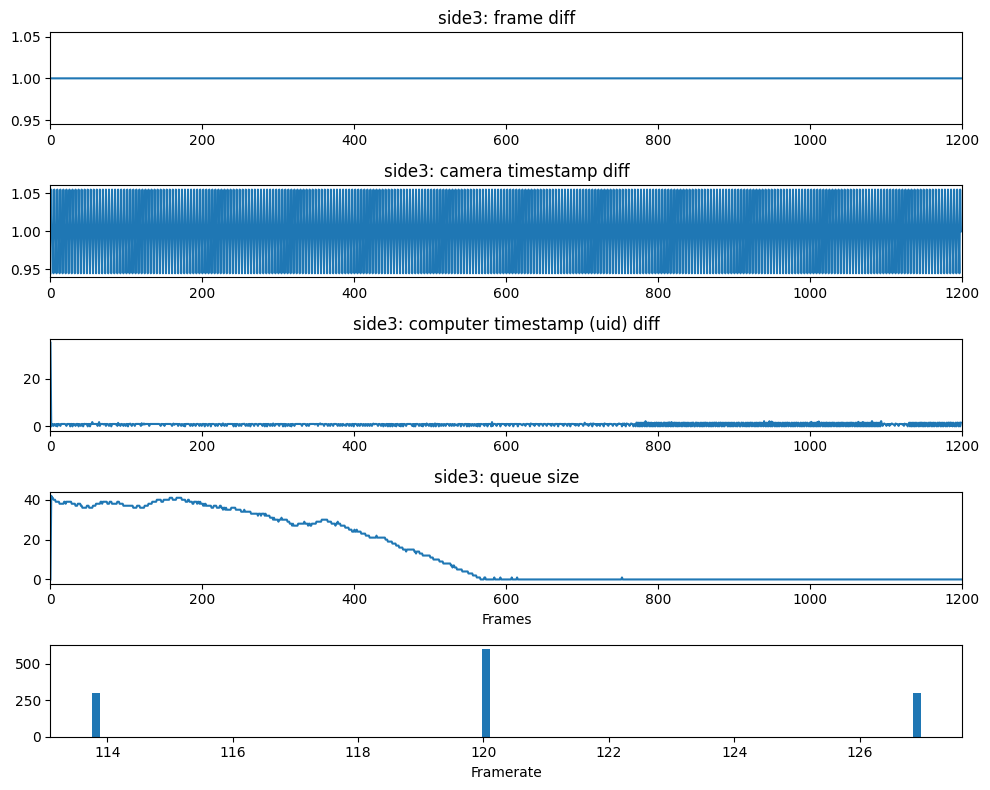

9.99177588
119.9986883612926
side4


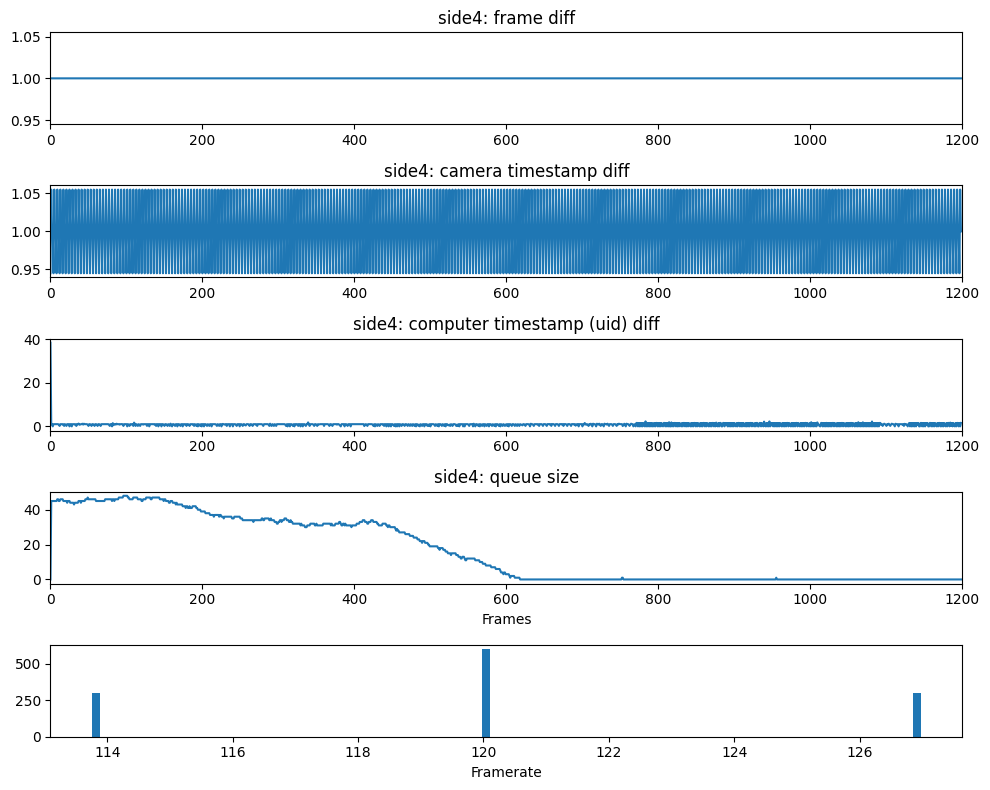

9.991790210000001
119.99851626188214
top


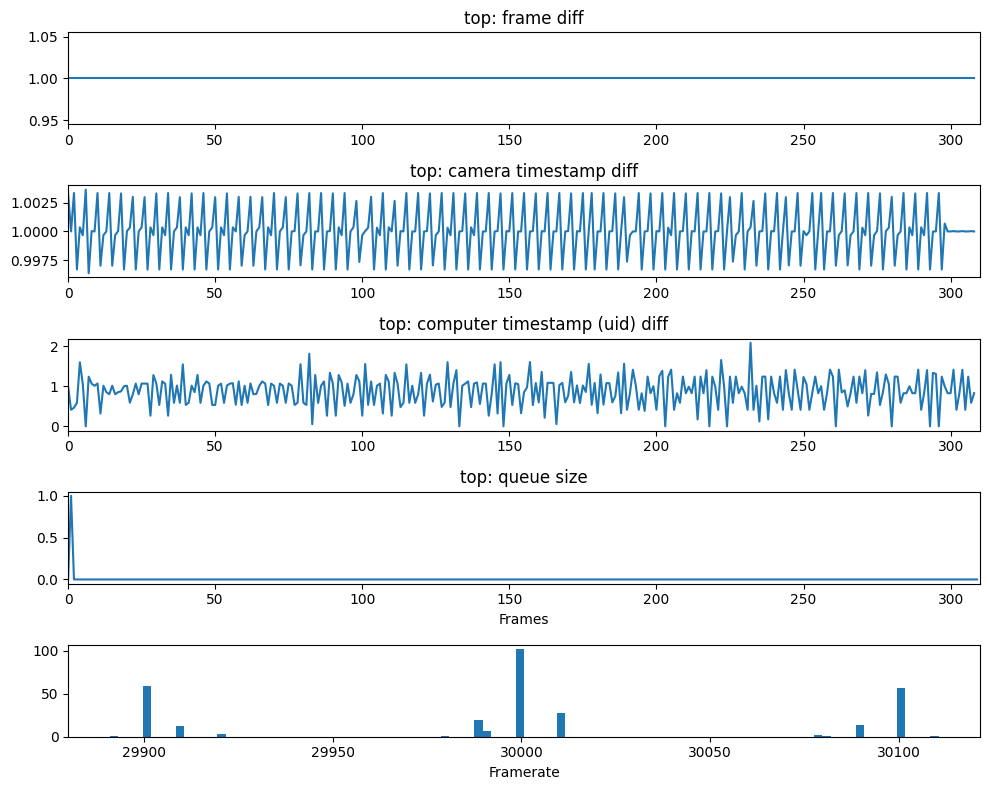

0.010300133000000001
29999.612626361235


In [10]:
for cam in config["cameras"]:
    name = cam
    print(name)
    df = pd.read_csv(glob.glob(str(save_loc)+ f'\*{name}.metadata.csv')[0])
    fig, axs = plt.subplots(ncols = 1, nrows = 5, gridspec_kw= {'height_ratios':[1,1,1,1,1]}, figsize=(10,8))
    nrows = len(df)
    axs[0].set_title(f"{name}: frame diff")
    axs[0].plot(np.diff(df.frame_num.values))
    axs[0].set_xlim([0, len(df)])
    axs[1].set_title(f"{name}: camera timestamp diff")
    axs[1].plot(np.diff(df.frame_timestamp.values) / np.median(np.diff(df.frame_timestamp.values)))
    #axs[1].plot(np.diff(df.frame_timestamp.values))
    axs[1].set_xlim([0, len(df)])
    axs[2].set_title(f"{name}: computer timestamp (uid) diff")
    axs[2].plot(np.diff(df.frame_image_uid.values) / np.median(np.diff(df.frame_image_uid.values)))
    axs[2].set_xlim([0, len(df)])
    axs[3].set_title(f"{name}: queue size")
    axs[3].plot(df.queue_size.values)
    axs[3].set_xlim([0, len(df)])
    axs[3].set_xlabel('Frames')
    axs[4].hist(1/(np.diff(df.frame_timestamp.values)* 1e-9), bins=100);
    axs[4].set_xlabel('Framerate')
    plt.tight_layout()
    plt.show()
    
    time_elapsed = (df.frame_timestamp.values[-1] - df.frame_timestamp.values[0]) * 1e-9
    avg_framerate = np.mean(np.diff(df.frame_timestamp.values))
    print(time_elapsed)
    print(1 / (avg_framerate* 1e-9))